In [1]:
%pip install qiskit
%pip install 'qiskit[visualization]'
%pip install qiskit-ibm-runtime
%pip install qiskit-addon-sqd
%pip install ffsim
%pip install pyscf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=27b4b25aab67fd195d8959e6e860b7dc5713bb317b5c48581ea0adde3e9f63b3
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.8/366.8 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Save your API key to track your progress and have access to the quantum computers

your_api_key = "JIiQzCBgz5r8_p4uuaykNyuVgnqmtp7eTnMhVtborD1q"
your_crn = "crn:v1:bluemix:public:quantum-computing:us-east:a/777616dc7ccc43afb09ff5ced897ba32:00beb17d-f5b2-4058-96eb-489163068998::"

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
    name="qgss-2025",
    overwrite=True
)

In [3]:
import qiskit
print(f"Qiskit version: {qiskit.__version__}")

Qiskit version: 2.1.2


In [4]:
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()

{'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'JIiQzCBgz5r8_p4uuaykNyuVgnqmtp7eTnMhVtborD1q',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/777616dc7ccc43afb09ff5ced897ba32:00beb17d-f5b2-4058-96eb-489163068998::',
  'verify': True,
  'private_endpoint': False}}

In [5]:
# Import common packages first
import numpy as np
from math import comb
import warnings
import pyscf
import matplotlib.pyplot as plt
import pickle
from functools import partial

# Import qiskit classes
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# Import qiskit ecosystems
import ffsim
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime import SamplerOptions


In [6]:
from math import comb

# CO2 parameters
alpha_e = 11
beta_e = 11
spatial_orbitals_CO2 = [13, 21, 30]  # STO-3G, 6-31G, cc-pVDZ
labels = ['STO-3G', '6-31G', 'cc-pVDZ']

total_configs_CO2 = []
for n_orb in spatial_orbitals_CO2:
    spin_orb = n_orb  # number of spatial orbitals used in comb
    alpha_config = comb(spin_orb, alpha_e)
    beta_config = comb(spin_orb, beta_e)
    total_configs_CO2.append(alpha_config * beta_config)
    print(f"{n_orb}-orbital basis: α={alpha_config}, β={beta_config}, total={alpha_config*beta_config}")


13-orbital basis: α=78, β=78, total=6084
21-orbital basis: α=352716, β=352716, total=124408576656
30-orbital basis: α=54627300, β=54627300, total=2984141905290000


The output shows how the number of possible electronic configurations grows rapidly as the number of spatial orbitals (and thus the basis set size) increases. This highlights the challenge of simulating molecular systems on classical computers due to the exponential growth of the configuration space.

In [7]:
# NH3 parameters
alpha_e = 5
beta_e = 5
spatial_orbitals_NH3 = [7, 13, 18]
labels = ['STO-3G', '6-31G', 'cc-pVDZ']

total_configs_NH3 = []
for n_orb in spatial_orbitals_NH3:
    spin_orb = n_orb  # number of spatial orbitals used in comb
    alpha_config = comb(spin_orb, alpha_e)
    beta_config = comb(spin_orb, beta_e)
    total_configs_NH3.append(alpha_config * beta_config)
    print(f"{n_orb}-orbital basis: α={alpha_config}, β={beta_config}, total={alpha_config*beta_config}")


7-orbital basis: α=21, β=21, total=441
13-orbital basis: α=1287, β=1287, total=1656369
18-orbital basis: α=8568, β=8568, total=73410624


In [8]:
#nh3
α_config = 21
β_config = 21
total_config = (α_config)*(β_config)
# --- End of TODO ---

print(f"Total physical configurations for NH3 in the given basis : {α_config:} x {β_config:} = {total_config}")

Total physical configurations for NH3 in the given basis : 21 x 21 = 441


In [ ]:
total_config = 441

#1 Mapping

In [9]:
import warnings
import pyscf

warnings.filterwarnings("ignore")

# Specify molecule properties
open_shell = False
spin_sq = 0  # singlet

# Build CO2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[
        ["C", (0.0, 0.0, 0.0)],       # Carbon at origin
        ["O", (0.0, 0.0, 1.16)],      # Oxygen along z-axis (bond length ~1.16 Å)
        ["O", (0.0, 0.0, -1.16)],     # Oxygen opposite side
    ],
    basis="STO-3G",
    symmetry="Dooh"                  # CO2 has D∞h, approximate with Doo_h in PySCF
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2

# Run CASCI calculation
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot
print(f"Exact CASCI energy for CO2: {exact_energy:.6f} Ha")


converged SCF energy = -185.064695682222
CASCI E = -185.275951946650  E(CI) = -109.428242942513  S^2 = 0.0000000
Exact CASCI energy for CO2: -185.275952 Ha


In [10]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -185.2557089826656  E_corr = -0.191013300443768


In [11]:
import numpy as np

# أعادة تسمية لسهولة التتبع
t1_co2, t2_co2 = t1, t2

# احفظهم بوضوح على الديسك
np.save("t1_co2.npy", t1_co2)
np.save("t2_co2.npy", t2_co2)

# للتأكد
print("Saved:", t1_co2.shape, t2_co2.shape)


Saved: (9, 4) (9, 9, 4, 4)


In [12]:
# --- NH3 CCSD in PySCF + save t1/t2 ---
import numpy as np
from pyscf import gto, scf, cc

# اختَر نفس الـ basis اللي استخدمته في CO2 لثبات النتائج
BASIS = "cc-pVDZ"  # غيّرها لو كنت مستخدم basis مختلف في ملف CO2

# هندسة تقريبية لـ NH3 (هرميّة بزاوية ~107°)
mol = gto.Mole()
mol.atom = """
N  0.000000  0.000000  0.000000
H  0.000000  0.937700  0.381600
H  0.812100 -0.468900  0.381600
H -0.812100 -0.468900  0.381600
"""
mol.unit  = "Angstrom"
mol.basis = BASIS
mol.charge = 0
mol.spin   = 0   # مغزول مُقفَل (alpha=beta)
mol.build()

# RHF
mf = scf.RHF(mol).run()

# (اختياري) تجميد نواة N-1s لتقليل الـ active space
# لو عايز من غير تجميد: سيب السطر اللي تحت متعلّق واستعمل cc.CCSD(mf).run()
# الملاحظة: frozen=1 يعني تجميد أقلّ مدار مُحتل مزدوج (core)
ccsd_nh3 = cc.CCSD(mf, frozen=1).run()   # أو cc.CCSD(mf).run()

# أمبليتيودات CCSD
t1_nh3, t2_nh3 = ccsd_nh3.t1, ccsd_nh3.t2
print("t1_nh3 shape:", t1_nh3.shape, " | t2_nh3 shape:", t2_nh3.shape)

# خزّنهم للتحميل لاحقًا
np.save("t1_nh3.npy", t1_nh3)
np.save("t2_nh3.npy", t2_nh3)
print("Saved: t1_nh3.npy, t2_nh3.npy")


converged SCF energy = -56.1956196688638
E(CCSD) = -56.39817752189853  E_corr = -0.2025578530347328
t1_nh3 shape: (4, 24)  | t2_nh3 shape: (4, 4, 24, 24)
Saved: t1_nh3.npy, t2_nh3.npy


In [13]:
t1_nh3, t2_nh3 = ccsd_nh3.t1, ccsd_nh3.t2
np.save("t1_nh3.npy", t1_nh3)
np.save("t2_nh3.npy", t2_nh3)


In [14]:
import numpy as np
import ffsim
from qiskit import QuantumRegister, QuantumCircuit

# --- حمّل أمبليتيودات PySCF ---
t1 = np.load("t1_co2.npy")  # (nocc, nvir)
t2 = np.load("t2_co2.npy")  # (nocc, nocc, nvir, nvir)
nocc, nvir = t1.shape
n_spatial = nocc + nvir           # = 13 من ديباغك
n_spin_orbs = 2 * n_spatial       # = 26

# --- أزواج التفاعل على المدارّات المكانية ---
alpha_alpha = [(p, p+1) for p in range(n_spatial - 1)]
alpha_beta  = [(p, p)   for p in range(n_spatial)]

# --- UCJ operator & gate (26 كيوبت) ---
ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t1=t1, t2=t2, n_reps=1,
    interaction_pairs=(alpha_alpha, alpha_beta),
)
ucj_gate = ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op)
assert ucj_gate.num_qubits == n_spin_orbs  # 26

# --- HF gate لازم نمرّره n_spatial (مش 2*n_spatial) ---
num_elec_a = num_elec_b = nocc  # = 9,9 في الـ active space
hf_gate = ffsim.qiskit.PrepareHartreeFockJW(n_spatial, (num_elec_a, num_elec_b))
assert hf_gate.num_qubits == n_spin_orbs   # 26

# --- ابنِ الدائرة على 26 كيوبت بالضبط ---
q = QuantumRegister(n_spin_orbs, "q")
qc = QuantumCircuit(q)
qc.append(hf_gate, q)
qc.append(ucj_gate, q)
qc.measure_all()

print("OK ✅  | qubits:", qc.num_qubits,
      "| nocc:", nocc, "nvir:", nvir,
      "| electrons (α,β):", (num_elec_a, num_elec_b))


OK ✅  | qubits: 26 | nocc: 9 nvir: 4 | electrons (α,β): (9, 9)


In [15]:
import ffsim
from qiskit import QuantumRegister, QuantumCircuit

def build_ucj_circuit(t1, t2, num_elec_a, num_elec_b, n_reps=1):
    n_alpha = t1.shape[0]
    n_beta = t1.shape[1]

    # Interaction pairs only on active orbitals
    alpha_alpha_indices = [(p, p + 1) for p in range(n_alpha - 1)]
    alpha_beta_indices = [(p, p) for p in range(n_alpha)]

    # UCJ operator
    ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t1=t1,
        t2=t2,
        n_reps=n_reps,
        interaction_pairs=(alpha_alpha_indices, alpha_beta_indices)
    )

    # Total orbitals for HF preparation
    num_orbitals_total = n_alpha + n_beta
    total_qubits = 2 * num_orbitals_total

    qubits = QuantumRegister(total_qubits, name="q")
    circuit = QuantumCircuit(qubits)

    # Hartree-Fock reference
    circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals_total, (num_elec_a, num_elec_b)), qubits)

    # Apply UCJ operator
    circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
    circuit.measure_all()

    return circuit

# ------------------------
# CO2
circuit_co2 = build_ucj_circuit(t1_co2, t2_co2, num_elec_a=7, num_elec_b=7)
circuit_co2.decompose().decompose().draw("mpl", fold=-1)

# ------------------------
# NH3
circuit_nh3 = build_ucj_circuit(t1_nh3, t2_nh3, num_elec_a=3, num_elec_b=2)
circuit_nh3.decompose().decompose().draw("mpl", fold=-1)


#2 Optimization

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Load or authenticate your IBM Quantum account
service = QiskitRuntimeService(name="qgss-2025")  # 'name' is optional if already saved

# Select the backend
backend = service.backend("ibm_brisbane")



In [17]:
import numpy as np
import ffsim
from qiskit import QuantumRegister, QuantumCircuit

def build_ucj_circuit(t1, t2, num_elec_a, num_elec_b, n_reps=1):
    # في تمثيل spin-balanced: t1.shape = (n_alpha_spin_orbs, n_beta_spin_orbs)
    n_alpha = int(t1.shape[0])
    n_beta  = int(t1.shape[1])

    # عدد المدارّات "المكانية" = أكبر عدد على أحد السبنين (لأن لكل مدار مكاني مدارين سبينيين)
    n_spatial = max(n_alpha, n_beta)        # <-- كان عندك sum، والصحيح max هنا
    num_spin_orbitals = 2 * n_spatial       # <-- spin orbitals = 2 × spatial

    # فحوصات سريعة
    assert num_elec_a + num_elec_b <= num_spin_orbitals, \
        f"Too many electrons ({num_elec_a + num_elec_b}) for {num_spin_orbitals} spin orbitals."
    assert t2.ndim == 4, "t2 must be rank-4 (p,q,r,s)."
    assert t2.shape == (n_alpha, n_beta, n_alpha, n_beta), "t2 shape must match (nα,nβ,nα,nβ)."

    # أزواج التفاعل على المدارّات "المكانية"
    alpha_alpha_indices = [(p, p + 1) for p in range(n_spatial - 1)]
    alpha_beta_indices  = [(p, p)     for p in range(n_spatial)]

    # UCJ operator & gate
    ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t1=t1, t2=t2, n_reps=n_reps,
        interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    )
    ucj_gate = ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op)
    assert ucj_gate.num_qubits == num_spin_orbitals, \
        f"UCJ expects {ucj_gate.num_qubits} != computed {num_spin_orbitals}"

    # حضّر المرجع HF: مرّر عدد المدارّات "المكانية" (مش spin orbitals!)
    hf_gate = ffsim.qiskit.PrepareHartreeFockJW(n_spatial, (num_elec_a, num_elec_b))
    assert hf_gate.num_qubits == num_spin_orbitals, \
        f"HF expects {hf_gate.num_qubits} != {num_spin_orbitals}"

    # ابنِ الدائرة على عدد spin orbitals
    q = QuantumRegister(num_spin_orbitals, name="q")
    qc = QuantumCircuit(q)
    qc.append(hf_gate, q)
    qc.append(ucj_gate, q)
    qc.measure_all()
    return qc


#3 Execution

In [18]:
import numpy as np

bit_array = {f"q{i}": i for i in range(circuit_co2.num_qubits)}
bit_array = np.array(list(bit_array.values()))
print(bit_array)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [19]:
np.save("CO2_device_bitarray.npy", bit_array)


In [20]:
bit_array = np.load("CO2_device_bitarray.npy", allow_pickle=True)


In [21]:
bit_array = {f"q{i}": i for i in range(qc.num_qubits)}
bit_array = np.array(list(bit_array.values()))


#4 Post-Processing

In [22]:
# ---------- 4) Post-Processing ----------
import numpy as np

def counts_to_probs(counts):
    """حوّل dict العدّات إلى احتمالات مصححة."""
    shots = sum(counts.values())
    return {bitstr: c / shots for bitstr, c in counts.items()}

def bitstr_to_bits(bitstr, n_qubits):
    """
    Qiskit بترجع الـ bitstring من الـ clbits بترتيب big-endian:
    أقصى يسار = أعلى clbit index. ومع measure_all (1:1) بنعكس السلسلة عشان نجيب
    ترتيب البتات من qubit 0 (LSB) لحد qubit n-1 (MSB).
    """
    s = bitstr.replace(" ", "")
    if len(s) != n_qubits:
        # لو Qiskit رجّعت prefix قصير، نكمِّل أصفار على الشمال
        s = s.zfill(n_qubits)
    # اعكس عشان تبقى bit 0 هو qubit 0
    return np.array(list(s[::-1]), dtype=int)

def split_alpha_beta(bits, n_spatial):
    """
    نحول من ترتيب [α0..α(n-1), β0..β(n-1)] إلى مصفوفتين منفصلتين (alpha, beta).
    """
    alpha = bits[:n_spatial]
    beta  = bits[n_spatial:2*n_spatial]
    return alpha, beta

def expectation_number_alpha_beta(probs, n_qubits, n_spatial):
    """
    〈Nα〉 و 〈Nβ〉 و 〈N〉 و 〈Sz〉 من توزيعات الحالات.
    """
    N_alpha = 0.0
    N_beta  = 0.0
    for bitstr, p in probs.items():
        bits = bitstr_to_bits(bitstr, n_qubits)
        alpha, beta = split_alpha_beta(bits, n_spatial)
        N_alpha += alpha.sum() * p
        N_beta  += beta.sum()  * p
    N_tot = N_alpha + N_beta
    Sz = 0.5 * (N_alpha - N_beta)
    return N_alpha, N_beta, N_tot, Sz

def orbital_occupancies(probs, n_qubits, n_spatial):
    """
    〈n_{pα}〉, 〈n_{pβ}〉, و 〈n_p〉 لكل مدار مكاني p.
    """
    occ_alpha = np.zeros(n_spatial)
    occ_beta  = np.zeros(n_spatial)
    for bitstr, p in probs.items():
        bits = bitstr_to_bits(bitstr, n_qubits)
        alpha, beta = split_alpha_beta(bits, n_spatial)
        occ_alpha += alpha * p
        occ_beta  += beta  * p
    occ_spatial = occ_alpha + occ_beta
    return occ_alpha, occ_beta, occ_spatial

def marginal_distribution(probs, n_qubits, select_indices):
    """
    توزيع هامشي على subset من الكيوبتس (e.g. كل α أو كل β أو مدار معين).
    select_indices: list of qubit indices (0-based) في الترتيب المنطقي.
    """
    marg = {}
    for bitstr, p in probs.items():
        bits = bitstr_to_bits(bitstr, n_qubits)
        key = "".join(str(bits[i]) for i in select_indices)  # LSB→MSB لنفس subset
        marg[key] = marg.get(key, 0.0) + p
    return marg

# ===== مثال استخدام سريع =====
# اختَر اسم الدائرة اللي عندك (qc أو circuit_co2 أو hardware_ready_circuit قبل القياس)
try_names = ["circuit_co2", "qc", "hardware_ready_circuit", "circuit"]
circ = None
for name in try_names:
    if name in globals():
        circ = globals()[name]
        break
if circ is None:
    raise NameError("لم أجد دائرة باسم circuit_co2 أو qc أو hardware_ready_circuit. سمّي المتغير هنا.")

n_qubits = circ.num_qubits

# عدد المدارّات المكانية n_spatial:
# لو كنت باني الدائرة بـ PrepareHartreeFockJW(n_spatial, ...) فـ n_qubits = 2*n_spatial
assert n_qubits % 2 == 0, "عدد الكيوبتس لازم يكون زوجي (α/β)."
n_spatial = n_qubits // 2

# لو عندك counts من تنفيذ فعلي أو محاكاة:
#   - للهاردوير/Runtime Sampler: استخرج counts من النتيجة
#   - للمحاكاة: ممكن تستخدم Aer qasm_simulator أو BackendV2Simulator
# هنا هنحط مثال تخيّلي؛ استبدل `counts` بنتيجتك الفعلية:
# counts = result.get_counts()  # ← مثال
try:
    counts
except NameError:
    # Dummy counts كتجربة (حالة HF واحدة)
    # كل الكيوبتس α مشغولة لأول num_elec_a ومدارات β لأول num_elec_b
    # بدّل num_elec_a/b بالقيم الفعلية لو عايز تولّد حالة مرجعية تقريبية
    num_elec_a = num_elec_b = n_spatial // 2
    hf_bits = np.zeros(n_qubits, dtype=int)
    hf_bits[:num_elec_a] = 1                 # α block
    hf_bits[n_spatial:n_spatial+num_elec_b] = 1  # β block
    # رجّعها bitstring بترتيب Qiskit (اعكس)
    bitstr = "".join(map(str, hf_bits[::-1]))
    counts = {bitstr: 1024}

# 1) احتمالات الحالات
probs = counts_to_probs(counts)

# 2) أعداد الإلكترونات و Sz
N_alpha, N_beta, N_tot, Sz = expectation_number_alpha_beta(probs, n_qubits, n_spatial)

# 3) Occupancy لكل مدار
occ_a, occ_b, occ_spatial = orbital_occupancies(probs, n_qubits, n_spatial)

# 4) أمثلة marginals:
alpha_indices = list(range(0, n_spatial))                 # كل α
beta_indices  = list(range(n_spatial, 2*n_spatial))       # كل β
marg_alpha = marginal_distribution(probs, n_qubits, alpha_indices)
marg_beta  = marginal_distribution(probs, n_qubits, beta_indices)

print(f"〈Nα〉={N_alpha:.6f} | 〈Nβ〉={N_beta:.6f} | 〈N〉={N_tot:.6f} | 〈Sz〉={Sz:.6f}")
print("〈n_p〉 spatial (first few):", np.round(occ_spatial[:min(10, n_spatial)], 6))
print("Marginal α size:", len(marg_alpha), "| Marginal β size:", len(marg_beta))


〈Nα〉=6.000000 | 〈Nβ〉=6.000000 | 〈N〉=12.000000 | 〈Sz〉=0.000000
〈n_p〉 spatial (first few): [2. 2. 2. 2. 2. 2. 0. 0. 0. 0.]
Marginal α size: 1 | Marginal β size: 1


In [23]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

# تأكد إن circuit_co2 موجود وفيه measure_all()
assert "circuit_co2" in globals(), "ابنِ circuit_co2 أولًا."

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")   # ← خُد كائن backend بدل الاسم النصّي

with Session(backend=backend) as session:    # ← مرّر الكائن هنا
    sampler = Sampler(session=session)
    # بعض الإصدارات تتطلب 'circuits=' وبالبنية قائمة
    job = sampler.run(circuits=[circuit_co2], shots=2048)
    result = job.result()

# متوافق مع اختلافات الإصدارات
quasi = result.quasi_dists[0] if hasattr(result, "quasi_dists") else result[0]
print("Quasi (first few):", list(dict(quasi).items())[:5])

# (اختياري) counts تقريبية
shots = 2048
counts = {bitstr: int(prob * shots) for bitstr, prob in dict(quasi).items()}
print("Approx counts (first few):", list(counts.items())[:5])


RequestsApiError: '400 Client Error: Bad Request for url: https://quantum.cloud.ibm.com/api/v1/sessions. {"errors":[{"code":1352,"message":"You are not authorized to run a session when using the open plan.","solution":"Create an instance of a different plan type or use a different execution mode <https://quantum.cloud.ibm.com/docs/guides/execution-modes>.","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"a31fd54f-e63c-4e28-8b4f-51153a4ba221"}\n'

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backends = service.backends()
print("Available backends:", [b.name for b in backends])


In [ ]:
from qiskit_ibm_runtime import Options
opts = Options()
print(opts)           # هتلاقي الحقول/القيم الافتراضية
print(type(opts))     # تأكيد إنه OptionsV2


In [ ]:
%pip install qiskit qiskit-aer qiskit-ibm-runtime ffsim pyscf matplotlib

In [ ]:
import qiskit
import ffsim
import pyscf
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
import matplotlib.pyplot as plt


In [ ]:
from qiskit_aer import AerSimulator
from qiskit import transpile

# اختَر الدائرة اللي عندك (لازم فيها measure_all())
circ = circuit_co2  # أو qc لو ده اسمها عندك

sim = AerSimulator()
tqc = transpile(circ, sim)
job = sim.run(tqc, shots=2048, seed_simulator=42)
result = job.result()

counts = result.get_counts()
print("Local counts (first few):", list(counts.items())[:5])

# احتمالات (لو محتاج)
shots = sum(counts.values())
probs = {b: c / shots for b, c in counts.items()}
print("Prob sum:", sum(probs.values()))


In [ ]:
import numpy as np

def as_probs_from_counts_or_quasi(obj):
    """Convert counts (dict of bitstring->int) or quasi (bitstring->prob) to probabilities."""
    if not obj:
        return {}
    any_val = next(iter(obj.values()))
    if isinstance(any_val, (int, np.integer)):
        shots = sum(obj.values())
        return {b: c/shots for b, c in obj.items()}
    else:
        return dict(obj)

def bitstr_to_bits(bitstr, n_qubits):
    """Convert bitstring to bit array, reversed so qubit0 is index 0."""
    s = bitstr.replace(" ", "").zfill(n_qubits)
    return np.array(list(s[::-1]), dtype=int)

def split_alpha_beta(bits, n_spatial):
    """Split bit array into alpha and beta blocks given number of spatial orbitals."""
    return bits[:n_spatial], bits[n_spatial:2*n_spatial]

def expectations(probs, n_qubits, n_spatial):
    """Compute <Nα>, <Nβ>, <N>, and <Sz> from probabilities."""
    Nalpha = Nbeta = 0.0
    for b, p in probs.items():
        bits = bitstr_to_bits(b, n_qubits)
        a, be = split_alpha_beta(bits, n_spatial)
        Nalpha += a.sum() * p
        Nbeta  += be.sum() * p
    N = Nalpha + Nbeta
    Sz = 0.5 * (Nalpha - Nbeta)
    return Nalpha, Nbeta, N, Sz

def occupancies(probs, n_qubits, n_spatial):
    """Compute orbital occupancies for alpha, beta, and total."""
    occ_a = np.zeros(n_spatial)
    occ_b = np.zeros(n_spatial)
    for b, p in probs.items():
        bits = bitstr_to_bits(b, n_qubits)
        a, be = split_alpha_beta(bits, n_spatial)
        occ_a += a * p
        occ_b += be * p
    return occ_a, occ_b, occ_a + occ_b

# --- Use counts (from Aer) or quasi (if Sampler worked) ---
# If you have quasi from Sampler V2:
#   quasi = result[0]
#   probs = as_probs_from_counts_or_quasi(quasi)
# Otherwise use counts:
probs = as_probs_from_counts_or_quasi(counts)

# Deduce number of spatial orbitals from qubits (half are alpha, half beta)
n_qubits = circ.num_qubits
assert n_qubits % 2 == 0, "Number of qubits must be even."
n_spatial = n_qubits // 2

# Compute expectations and occupancies
Nalpha, Nbeta, N, Sz = expectations(probs, n_qubits, n_spatial)
occ_a, occ_b, occ_spatial = occupancies(probs, n_qubits, n_spatial)

print(f"<Nα>={Nalpha:.6f} | <Nβ>={Nbeta:.6f} | <N>={N:.6f} | <Sz>={Sz:.6f}")
print("〈n_p〉 spatial (first 10):", np.round(occ_spatial[:min(10, n_spatial)], 6))


In [24]:
import pandas as pd

# Create DataFrame with occupancies
df = pd.DataFrame({
    "orbital": np.arange(n_spatial),
    "occ_alpha": occ_a,
    "occ_beta": occ_b,
    "occ_total": occ_spatial,
})

# Save to CSV
df.to_csv("occupancies.csv", index=False)
print("Saved occupancies to occupancies.csv")

# Save as NumPy arrays (optional)
np.save("occ_alpha.npy", occ_a)
np.save("occ_beta.npy", occ_b)
np.save("occ_total.npy", occ_spatial)
print("Saved occ_alpha.npy, occ_beta.npy, occ_total.npy")


Saved occupancies to occupancies.csv
Saved occ_alpha.npy, occ_beta.npy, occ_total.npy


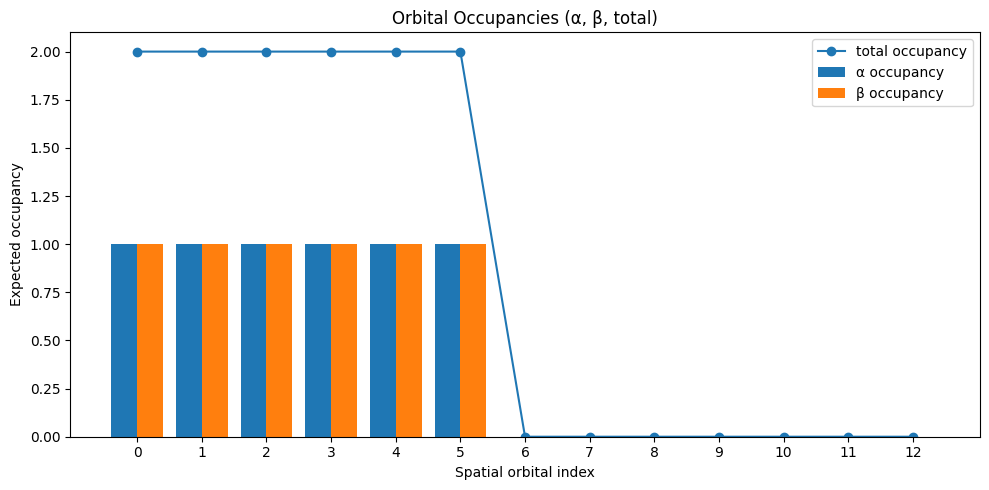

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes you already have:
# n_spatial, occ_a, occ_b, occ_spatial  (from your post-processing)

idx = np.arange(n_spatial)
bar_w = 0.4

plt.figure(figsize=(10, 5))
plt.bar(idx - bar_w/2, occ_a, width=bar_w, label="α occupancy")
plt.bar(idx + bar_w/2, occ_b, width=bar_w, label="β occupancy")
plt.plot(idx, occ_spatial, marker="o", linewidth=1.5, label="total occupancy")

plt.xlabel("Spatial orbital index")
plt.ylabel("Expected occupancy")
plt.title("Orbital Occupancies (α, β, total)")
plt.xticks(idx)  # لو عدد المدارات كبير وعايز تخفيف، استبدلها بـ: plt.xticks(idx[::2])
plt.legend()
plt.tight_layout()

# احفظ الرسم (اختياري)
plt.savefig("occupancies.png", dpi=150)
plt.show()


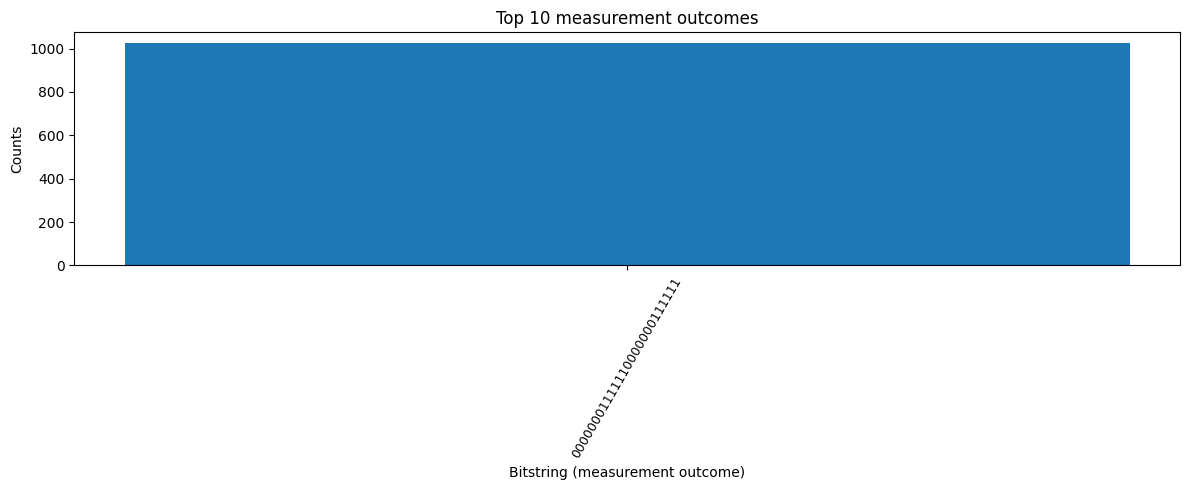

In [26]:
import matplotlib.pyplot as plt

# Use counts if you have them, otherwise reconstruct from probs
if 'counts' in globals():
    data = counts
else:
    shots = 2048
    data = {b: int(p*shots) for b,p in probs.items()}

# Sort outcomes by frequency
top_k = 10
top = sorted(data.items(), key=lambda x: x[1], reverse=True)[:top_k]
bitstrings, freqs = zip(*top)

plt.figure(figsize=(12, 5))
plt.bar(range(len(freqs)), freqs)
plt.xticks(range(len(freqs)), bitstrings, rotation=60, fontsize=9)
plt.xlabel("Bitstring (measurement outcome)")
plt.ylabel("Counts")
plt.title(f"Top {top_k} measurement outcomes")
plt.tight_layout()
plt.savefig("top_outcomes.png", dpi=150)
plt.show()


<Nα>=6.000000 | <Nβ>=6.000000 | <N>=12.000000 | <Sz>=0.000000
Total occupancy (first 10): [2. 2. 2. 2. 2. 2. 0. 0. 0. 0.]
Saved occupancies.csv + occ_alpha.npy/occ_beta.npy/occ_total.npy


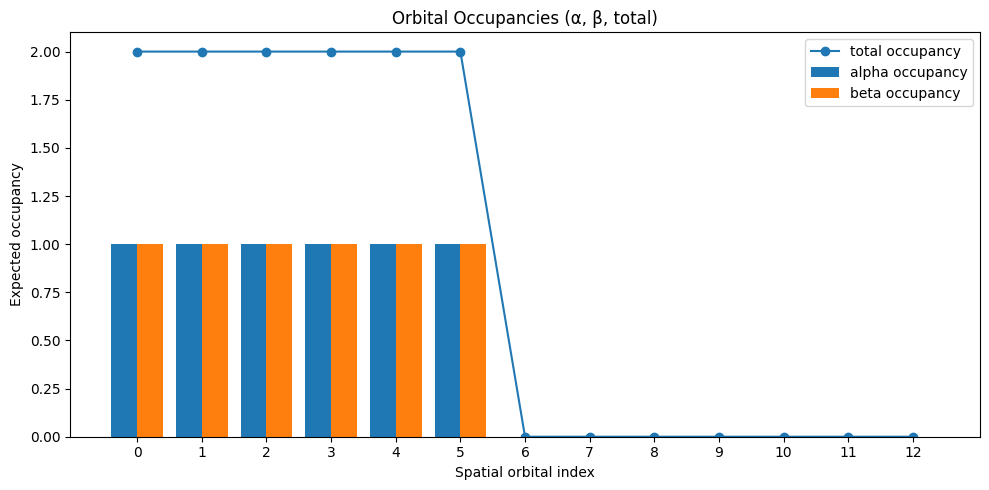

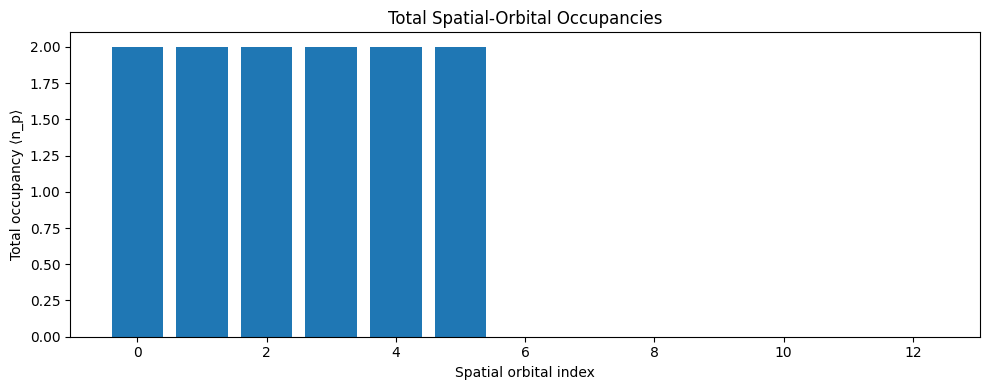

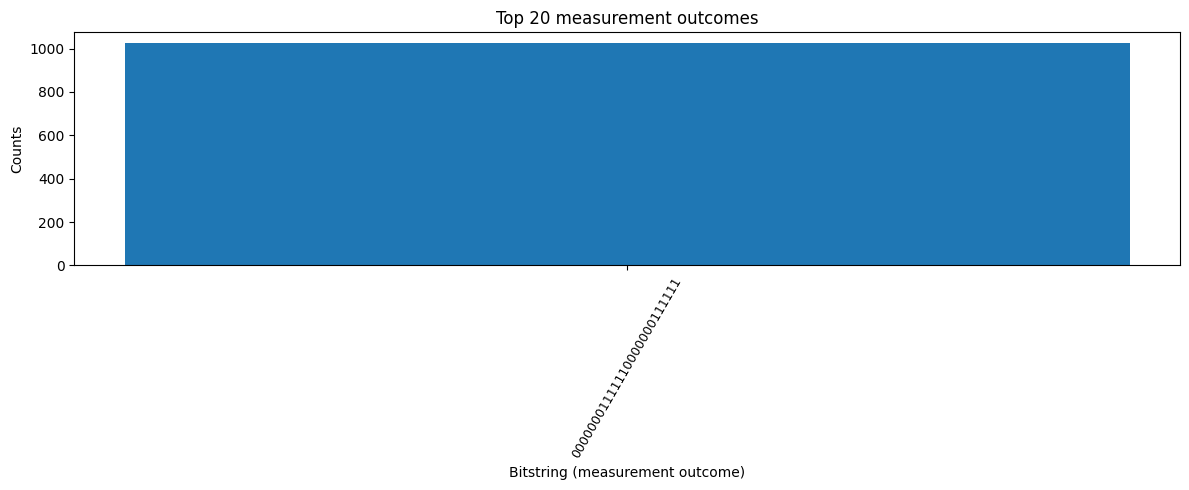

Saved top_outcomes.png / top_outcomes.csv / all_probabilities.csv


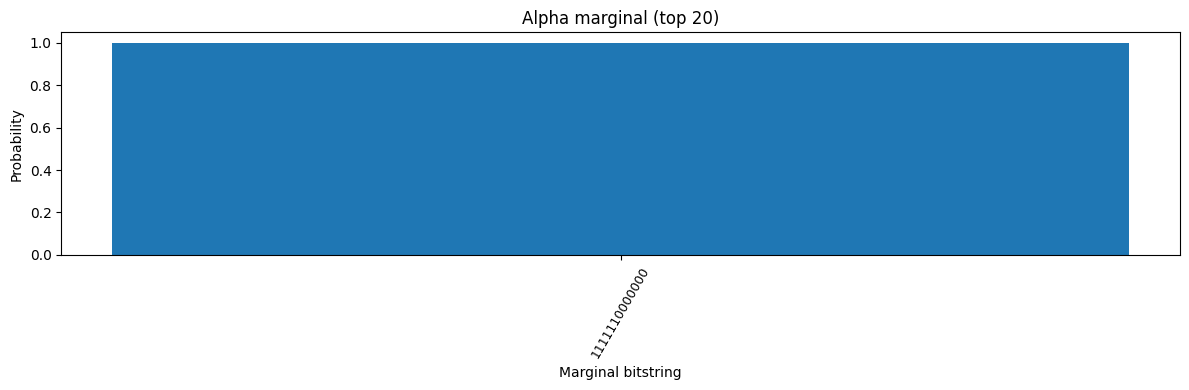

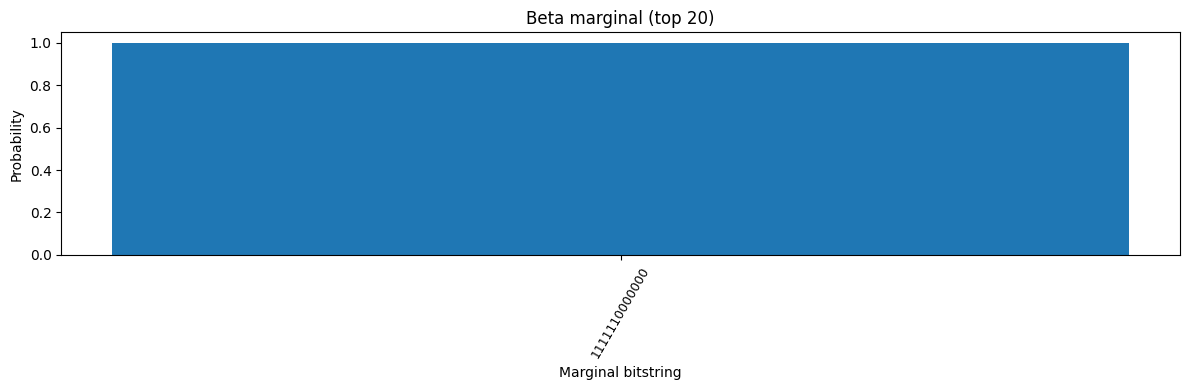

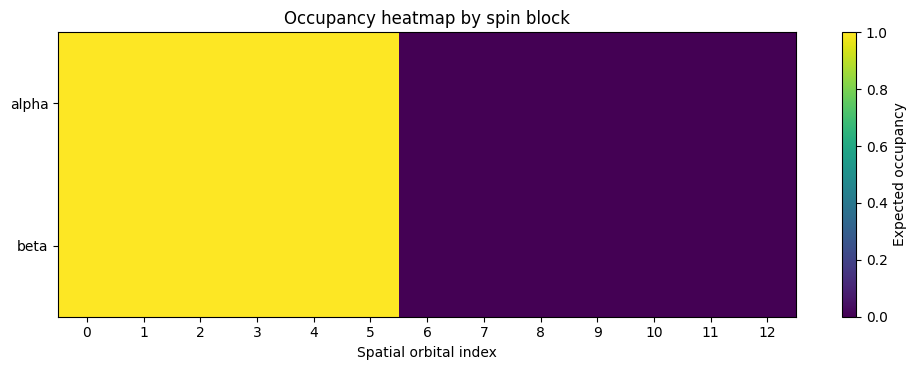

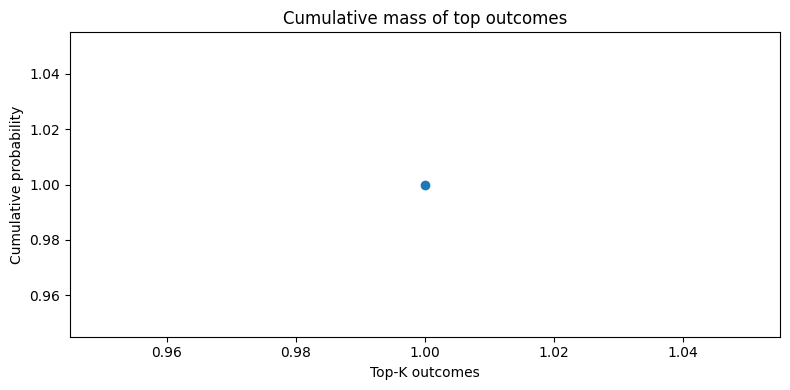

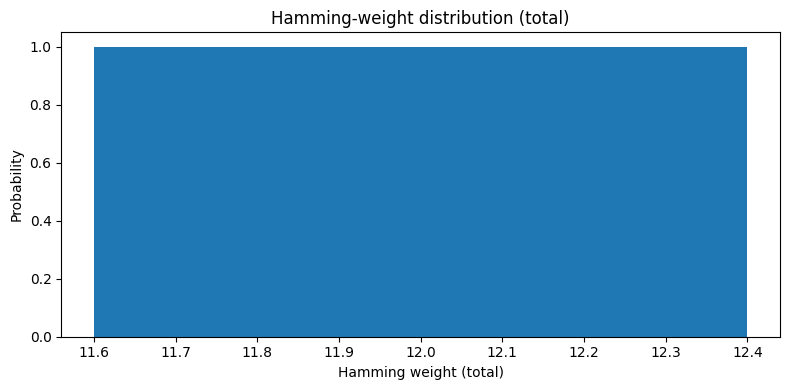

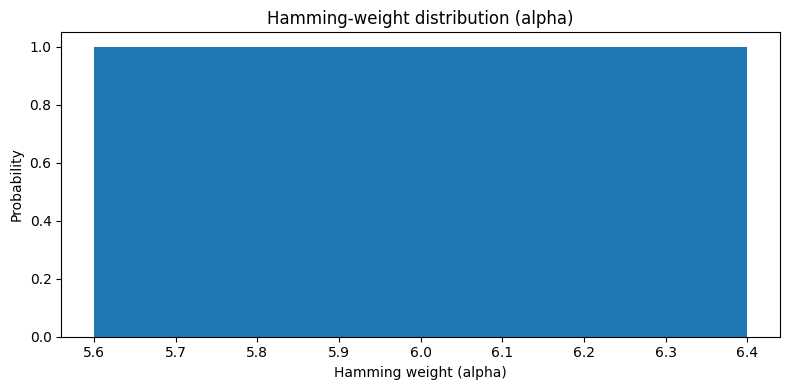

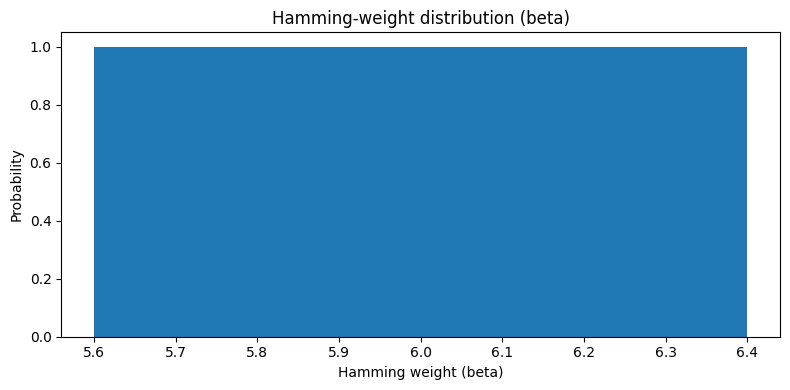

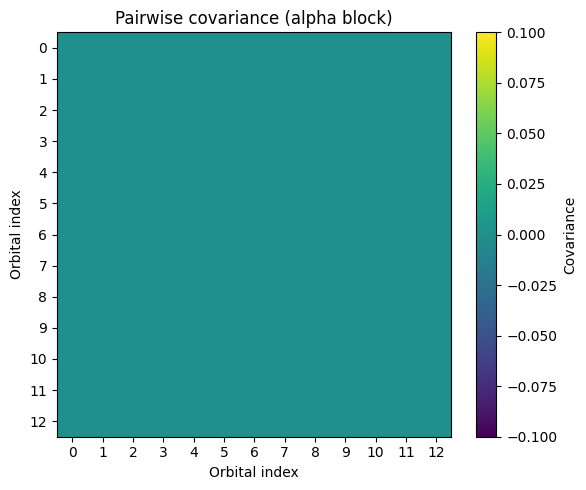

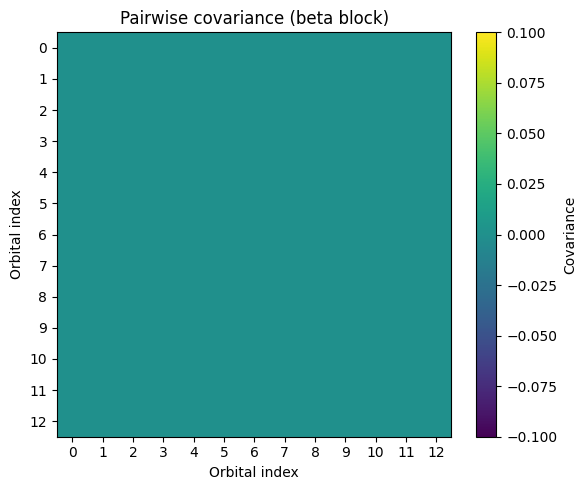

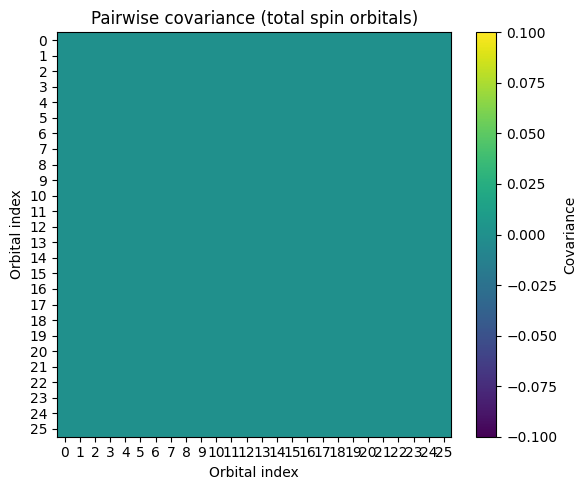

Saved correlation_alpha.csv / correlation_beta.csv / correlation_total.csv

✅ All plots and CSVs generated:
  - occupancies.png, occupancies_total.png, occupancy_heatmap.png
  - top_outcomes.png, cumulative_topk.png
  - hamming_weight_total.png, hamming_weight_alpha.png, hamming_weight_beta.png
  - corr_alpha.png, corr_beta.png, corr_total.png
  - occupancies.csv, top_outcomes.csv, all_probabilities.csv
  - correlation_alpha.csv, correlation_beta.csv, correlation_total.csv


In [27]:
# =========================
# Mega Post-Processing & Visualizations (All-in-One)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 0) Pick circuit & build probs ----------
# Try to find a circuit variable
_try_circ_names = ["circ", "circuit_co2", "qc", "hardware_ready_circuit", "circuit"]
_circ = None
for _n in _try_circ_names:
    if _n in globals():
        _circ = globals()[_n]
        break
if _circ is None:
    raise NameError("No circuit found. Define one of: circ / circuit_co2 / qc / hardware_ready_circuit / circuit")

n_qubits = _circ.num_qubits
assert n_qubits % 2 == 0, "Number of qubits must be even (alpha/beta split expected)."
n_spatial = n_qubits // 2

def as_probs_from_counts_or_quasi(obj):
    """Convert counts (bitstr->int) or quasi (bitstr->prob) to probabilities dict."""
    if not obj:
        return {}
    any_val = next(iter(obj.values()))
    if isinstance(any_val, (int, np.integer)):
        shots = sum(obj.values())
        return {b: c / shots for b, c in obj.items()}
    else:
        return dict(obj)

# Resolve probs smartly from available globals
if "counts" in globals():
    probs = as_probs_from_counts_or_quasi(globals()["counts"])
elif "quasi" in globals():
    probs = as_probs_from_counts_or_quasi(globals()["quasi"])
elif "result" in globals():
    # Try Sampler V1/V2 results
    res = globals()["result"]
    if hasattr(res, "quasi_dists"):  # Sampler V1 style
        probs = dict(res.quasi_dists[0])
    else:  # Sampler V2 style: result[0] is a mapping bitstr->prob
        probs = dict(res[0])
else:
    raise NameError("No counts/quasi/result found. Provide 'counts' (from Aer) or 'quasi'/'result' (from Sampler).")

# Normalize just in case
_norm = sum(probs.values())
if _norm <= 0:
    raise ValueError("Probability mass is zero. Check your counts/quasi.")
if abs(_norm - 1.0) > 1e-9:
    probs = {k: v / _norm for k, v in probs.items()}

# ---------- 1) Helpers ----------
def bitstr_to_bits(bitstr, n_qubits):
    s = bitstr.replace(" ", "").zfill(n_qubits)
    return np.array(list(s[::-1]), dtype=int)  # reverse so qubit0 at index 0

def split_alpha_beta(bits, n_spatial):
    return bits[:n_spatial], bits[n_spatial:2*n_spatial]

def expectations(probs, n_qubits, n_spatial):
    Nalpha = Nbeta = 0.0
    for b, p in probs.items():
        bits = bitstr_to_bits(b, n_qubits)
        a, be = split_alpha_beta(bits, n_spatial)
        Nalpha += a.sum() * p
        Nbeta  += be.sum() * p
    N = Nalpha + Nbeta
    Sz = 0.5 * (Nalpha - Nbeta)
    return Nalpha, Nbeta, N, Sz

def occupancies(probs, n_qubits, n_spatial):
    occ_a = np.zeros(n_spatial)
    occ_b = np.zeros(n_spatial)
    for b, p in probs.items():
        bits = bitstr_to_bits(b, n_qubits)
        a, be = split_alpha_beta(bits, n_spatial)
        occ_a += a * p
        occ_b += be * p
    return occ_a, occ_b, occ_a + occ_b

def marginal_distribution(probs, n_qubits, select_indices):
    marg = {}
    for bitstr, p in probs.items():
        s = bitstr.replace(" ", "").zfill(n_qubits)[::-1]
        key = "".join(s[i] for i in select_indices)
        marg[key] = marg.get(key, 0.0) + p
    return dict(sorted(marg.items(), key=lambda x: x[1], reverse=True))

# ---------- 2) Core expectations ----------
Nalpha, Nbeta, Ntot, Sz = expectations(probs, n_qubits, n_spatial)
occ_a, occ_b, occ_spatial = occupancies(probs, n_qubits, n_spatial)
print(f"<Nα>={Nalpha:.6f} | <Nβ>={Nbeta:.6f} | <N>={Ntot:.6f} | <Sz>={Sz:.6f}")
print("Total occupancy (first 10):", np.round(occ_spatial[:min(10, n_spatial)], 6))

# ---------- 3) Save Occupancies CSV/NPY ----------
df_occ = pd.DataFrame({
    "orbital": np.arange(n_spatial),
    "occ_alpha": occ_a,
    "occ_beta": occ_b,
    "occ_total": occ_spatial,
})
df_occ.to_csv("occupancies.csv", index=False)
np.save("occ_alpha.npy", occ_a)
np.save("occ_beta.npy",  occ_b)
np.save("occ_total.npy", occ_spatial)
print("Saved occupancies.csv + occ_alpha.npy/occ_beta.npy/occ_total.npy")

# ---------- 4) Plots: Occupancies (alpha/beta bars + total line) ----------
idx = np.arange(n_spatial)
bar_w = 0.4

plt.figure(figsize=(10, 5))
plt.bar(idx - bar_w/2, occ_a, width=bar_w, label="alpha occupancy")
plt.bar(idx + bar_w/2, occ_b, width=bar_w, label="beta occupancy")
plt.plot(idx, occ_spatial, marker="o", linewidth=1.5, label="total occupancy")
plt.xlabel("Spatial orbital index")
plt.ylabel("Expected occupancy")
plt.title("Orbital Occupancies (α, β, total)")
plt.xticks(idx)
plt.legend()
plt.tight_layout()
plt.savefig("occupancies.png", dpi=150)
plt.show()

# ---------- 5) Plot: Total occupancy only ----------
plt.figure(figsize=(10, 4))
plt.bar(idx, occ_spatial)
plt.xlabel("Spatial orbital index")
plt.ylabel("Total occupancy ⟨n_p⟩")
plt.title("Total Spatial-Orbital Occupancies")
plt.tight_layout()
plt.savefig("occupancies_total.png", dpi=150)
plt.show()

# ---------- 6) Top-k outcomes bar (counts-style) ----------
# Derive pseudo-counts if we only have probs
if "counts" in globals():
    data_counts = globals()["counts"]
else:
    SHOTS = 2048
    data_counts = {b: int(p * SHOTS) for b, p in probs.items()}
top_k = 20
_sorted = sorted(data_counts.items(), key=lambda x: x[1], reverse=True)[:top_k]
if _sorted:
    bitstrings, freqs = zip(*_sorted)
    plt.figure(figsize=(12, 5))
    plt.bar(range(len(freqs)), freqs)
    plt.xticks(range(len(freqs)), bitstrings, rotation=60, fontsize=9)
    plt.xlabel("Bitstring (measurement outcome)")
    plt.ylabel("Counts")
    plt.title(f"Top {top_k} measurement outcomes")
    plt.tight_layout()
    plt.savefig("top_outcomes.png", dpi=150)
    plt.show()

    # Save top outcomes CSV + all probabilities CSV
    df_top = pd.DataFrame({"bitstring": bitstrings, "counts": freqs})
    # attach probability
    _probs_for_csv = {b: probs.get(b, 0.0) for b in bitstrings}
    df_top["probability"] = df_top["bitstring"].map(_probs_for_csv)
    df_top.to_csv("top_outcomes.csv", index=False)
    df_probs = pd.DataFrame(sorted(probs.items(), key=lambda x: x[1], reverse=True),
                            columns=["bitstring", "probability"])
    df_probs.to_csv("all_probabilities.csv", index=False)
    print("Saved top_outcomes.png / top_outcomes.csv / all_probabilities.csv")

# ---------- 7) Marginals: alpha-only & beta-only ----------
alpha_idx = list(range(0, n_spatial))
beta_idx  = list(range(n_spatial, 2*n_spatial))
marg_a = marginal_distribution(probs, n_qubits, alpha_idx)
marg_b = marginal_distribution(probs, n_qubits, beta_idx)

def _plot_marginal(marg, title, filename, top=20):
    keys = list(marg.keys())[:top]
    vals = [marg[k] for k in keys]
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(vals)), vals)
    plt.xticks(range(len(vals)), keys, rotation=60, fontsize=9)
    plt.xlabel("Marginal bitstring")
    plt.ylabel("Probability")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    plt.show()

_plot_marginal(marg_a, f"Alpha marginal (top {top_k})", "marginal_alpha.png", top=top_k)
_plot_marginal(marg_b, f"Beta marginal (top {top_k})",  "marginal_beta.png",  top=top_k)

# ---------- 8) Heatmap: occupancy by spin block ----------
occ_mat = np.vstack([occ_a, occ_b])
plt.figure(figsize=(10, 3.8))
plt.imshow(occ_mat, aspect="auto")
plt.colorbar(label="Expected occupancy")
plt.yticks([0, 1], ["alpha", "beta"])
# If too many orbitals, thin ticks:
step = max(1, n_spatial // 16)
plt.xticks(np.arange(0, n_spatial, step))
plt.xlabel("Spatial orbital index")
plt.title("Occupancy heatmap by spin block")
plt.tight_layout()
plt.savefig("occupancy_heatmap.png", dpi=150)
plt.show()

# ---------- 9) Cumulative probability for top-K ----------
probs_sorted = sorted(probs.values(), reverse=True)
cum = np.cumsum(probs_sorted)
K = min(200, len(cum))
plt.figure(figsize=(8, 4))
plt.plot(range(1, K+1), cum[:K], marker="o", linewidth=1.5)
plt.xlabel("Top-K outcomes")
plt.ylabel("Cumulative probability")
plt.title("Cumulative mass of top outcomes")
plt.tight_layout()
plt.savefig("cumulative_topk.png", dpi=150)
plt.show()

# ---------- 10) Hamming weight distributions ----------
def hamming_weight(bits): return int(np.sum(bits))

def weight_histogram(probs, select="total"):
    # select: "alpha", "beta", "total"
    hist = {}
    for b, p in probs.items():
        bits = bitstr_to_bits(b, n_qubits)
        a, be = split_alpha_beta(bits, n_spatial)
        if select == "alpha":
            w = hamming_weight(a)
        elif select == "beta":
            w = hamming_weight(be)
        else:
            w = hamming_weight(bits)
        hist[w] = hist.get(w, 0.0) + p
    return dict(sorted(hist.items()))

for label in ["total", "alpha", "beta"]:
    wh = weight_histogram(probs, select=label)
    plt.figure(figsize=(8, 4))
    plt.bar(list(wh.keys()), list(wh.values()))
    plt.xlabel(f"Hamming weight ({label})")
    plt.ylabel("Probability")
    plt.title(f"Hamming-weight distribution ({label})")
    plt.tight_layout()
    plt.savefig(f"hamming_weight_{label}.png", dpi=150)
    plt.show()

# ---------- 11) Pairwise correlation heatmaps ----------
# For each i,j: Cov(n_i, n_j) = E[n_i n_j] - E[n_i]E[n_j]
def pairwise_cov(probs, which="alpha"):
    # which: "alpha", "beta", "total"
    if which == "alpha":
        L = n_spatial
        def pick(bits): return split_alpha_beta(bits, n_spatial)[0]
    elif which == "beta":
        L = n_spatial
        def pick(bits): return split_alpha_beta(bits, n_spatial)[1]
    else:
        L = 2 * n_spatial
        def pick(bits): return bits

    En = np.zeros(L)      # E[n_i]
    Enn = np.zeros((L, L))# E[n_i n_j]
    for b, p in probs.items():
        bits = bitstr_to_bits(b, n_qubits)
        sel = pick(bits)
        En += sel * p
        Enn += np.outer(sel, sel) * p
    cov = Enn - np.outer(En, En)
    return cov

cov_a = pairwise_cov(probs, "alpha")
cov_b = pairwise_cov(probs, "beta")
cov_t = pairwise_cov(probs, "total")

def _plot_cov(cov, title, fname, is_total=False):
    plt.figure(figsize=(6, 5))
    plt.imshow(cov, aspect="auto")
    plt.colorbar(label="Covariance")
    if is_total:
        step = max(1, cov.shape[0] // 16)
        plt.xticks(np.arange(0, cov.shape[1], step))
        plt.yticks(np.arange(0, cov.shape[0], step))
    else:
        step = max(1, n_spatial // 16)
        plt.xticks(np.arange(0, n_spatial, step))
        plt.yticks(np.arange(0, n_spatial, step))
    plt.xlabel("Orbital index")
    plt.ylabel("Orbital index")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.show()

_plot_cov(cov_a, "Pairwise covariance (alpha block)", "corr_alpha.png")
_plot_cov(cov_b, "Pairwise covariance (beta block)",  "corr_beta.png")
_plot_cov(cov_t, "Pairwise covariance (total spin orbitals)", "corr_total.png", is_total=True)

# ---------- 12) Save correlations as CSV ----------
pd.DataFrame(cov_a).to_csv("correlation_alpha.csv", index=False, header=False)
pd.DataFrame(cov_b).to_csv("correlation_beta.csv",  index=False, header=False)
pd.DataFrame(cov_t).to_csv("correlation_total.csv", index=False, header=False)
print("Saved correlation_alpha.csv / correlation_beta.csv / correlation_total.csv")

print("\n✅ All plots and CSVs generated:")
print("  - occupancies.png, occupancies_total.png, occupancy_heatmap.png")
print("  - top_outcomes.png, cumulative_topk.png")
print("  - hamming_weight_total.png, hamming_weight_alpha.png, hamming_weight_beta.png")
print("  - corr_alpha.png, corr_beta.png, corr_total.png")
print("  - occupancies.csv, top_outcomes.csv, all_probabilities.csv")
print("  - correlation_alpha.csv, correlation_beta.csv, correlation_total.csv")


In [28]:
def plot_energy_and_occupancy(result_history, exact_energy):

    # Data for energies plot
    x1 = range(len(result_history))
    min_e = [
        min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for result in result_history
    ]
    e_diff = [abs(e - exact_energy) for e in min_e]
    yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

    # Chemical accuracy (+/- 1 milli-Hartree)
    chem_accuracy = 0.001

    # Data for avg spatial orbital occupancy
    y2 = np.sum(result.orbital_occupancies, axis=0)
    x2 = range(len(y2))

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot energies
    axs[0].plot(x1, e_diff, label="energy error", marker="o")
    axs[0].set_xticks(x1)
    axs[0].set_xticklabels(x1)
    axs[0].set_yticks(yt1)
    axs[0].set_yticklabels(yt1)
    axs[0].set_yscale("log")
    axs[0].set_ylim(1e-4)
    axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
    axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
    axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
    axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
    axs[0].legend()

    # Plot orbital occupancy
    axs[1].bar(x2, y2, width=0.8)
    axs[1].set_xticks(x2)
    axs[1].set_xticklabels(x2)
    axs[1].set_title("Avg Occupancy per Spatial Orbital")
    axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
    axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

    print(f"Exact energy: {exact_energy:.5f} Ha")
    print(f"SQD energy: {min_e[-1]:.5f} Ha")
    print(f"Absolute error: {e_diff[-1]:.5f} Ha")
    plt.tight_layout()
    plt.show()

In [ ]:
%pip install qiskit-nature[pyscf]


In [34]:
%pip install qiskit-addon-sqd


In [35]:
all_results = {}

# مثال: geometry بتاعة CO2
geom = "CO2"

all_results[geom] = {
    "rhf_e": mf.e_tot,          # RHF energy من PySCF
    "cas_e": None,              # لو مش عامل CASCI خليها None
    "ccsd_e": ccsd.e_tot,       # CCSD total energy
    "t1": t1,                   # amplitudes
    "t2": t2,
    "mf": mf,                   # mean-field object (PySCF RHF/SCF)
    "h1cas": None,              # هيتملوا لو عملت CASCI
    "h2cas": None,
    "ncas": t1.shape[0],        # عدد المدارات active
    "nelecas": (num_elec_a, num_elec_b)  # عدد الإلكترونات α و β
}


[CO2] Skipping UCJ (ffsim/qiskit not available).
[CO2] Skipping SQD (qiskit_addon_sqd not available).


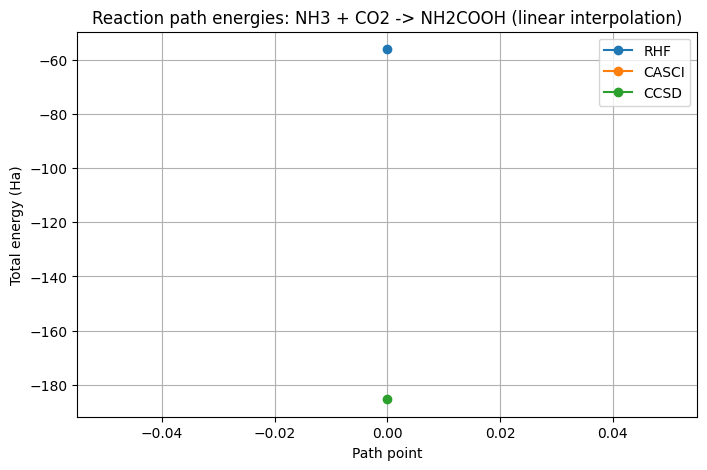


Summary table (point, RHF, CASCI, CCSD, SQD):
 0  -56.195620  nan  -185.255709  nan


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# 1. Flags
# =========================================================
try:
    import ffsim
    HAS_FFSIM = True
except ImportError:
    HAS_FFSIM = False

try:
    import qiskit, qiskit_aer
    HAS_QISKIT = True
except ImportError:
    HAS_QISKIT = False

try:
    from qiskit_addon_sqd import run_sqd_on_bitstrings
    HAS_SQD = True
except ImportError:
    HAS_SQD = False


# =========================================================
# 2. Functions
# =========================================================
def build_ucj_circuit_from_t(mf, t1, t2, n_orb, n_elec_a, n_elec_b, n_reps=1):
    """بناء دائرة UCJ من CCSD amplitudes"""
    from qiskit import QuantumCircuit, QuantumRegister

    ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t1=t1,
        t2=t2,
        n_reps=n_reps,
        interaction_pairs=None
    )

    qubits = QuantumRegister(2 * n_orb, "q")
    circuit = QuantumCircuit(qubits)

    # HF reference
    circuit.append(
        ffsim.qiskit.PrepareHartreeFockJW(n_orb, (n_elec_a, n_elec_b)),
        qubits
    )

    # UCJ ansatz
    circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

    circuit.measure_all()
    return circuit


def sample_circuit_get_counts(circuit, shots=200):
    """تشغيل دائرة Qiskit وجمع counts"""
    from qiskit_aer import Aer
    from qiskit import transpile

    backend = Aer.get_backend("aer_simulator")
    tqc = transpile(circuit, backend)
    job = backend.run(tqc, shots=shots)
    result = job.result()
    return result.get_counts()


def counts_to_bool_matrix(counts):
    """تحويل counts إلى مصفوفة Boolean"""
    n_qubits = len(next(iter(counts.keys())))
    total_shots = sum(counts.values())
    mat = np.zeros((total_shots, n_qubits), dtype=int)

    i = 0
    for bitstring, freq in counts.items():
        bits = np.array([int(b) for b in bitstring[::-1]])  # reverse Qiskit order
        for _ in range(freq):
            mat[i, :] = bits
            i += 1
    return mat


# =========================================================
# 3. Build all_results from PySCF outputs
# =========================================================
all_results = {}

# مثال: geometry بتاعة CO2
geom = "CO2"

all_results[geom] = {
    "rhf_e": mf.e_tot,          # RHF energy من PySCF
    "cas_e": None,              # لو مش عامل CASCI خليها None
    "ccsd_e": ccsd.e_tot,       # CCSD total energy
    "t1": t1,                   # amplitudes
    "t2": t2,
    "mf": mf,                   # mean-field object (PySCF RHF/SCF)
    "h1cas": None,              # يتملي لو عملت CASCI
    "h2cas": None,
    "ncas": t1.shape[0],        # عدد المدارات active
    "nelecas": (num_elec_a, num_elec_b)  # عدد الإلكترونات α و β
}


# =========================================================
# 4. Loop over geometries
# =========================================================
results = []

for geom, res in all_results.items():
    qc = None
    counts = None
    bool_mat = None
    sqd_result = None

    # Quantum UCJ circuit
    if res["t1"] is not None and res["t2"] is not None and HAS_FFSIM and HAS_QISKIT:
        n_orb = res["ncas"]
        n_elec_a, n_elec_b = res["nelecas"]

        qc = build_ucj_circuit_from_t(
            res["mf"], res["t1"], res["t2"], n_orb, n_elec_a, n_elec_b
        )
        if qc is not None:
            counts = sample_circuit_get_counts(qc, shots=200)
            bool_mat = counts_to_bool_matrix(counts)
            print(f"[{geom}] Sampled shots:", sum(counts.values()) if counts else 0)
    else:
        if not HAS_FFSIM or not HAS_QISKIT:
            print(f"[{geom}] Skipping UCJ (ffsim/qiskit not available).")
        else:
            print(f"[{geom}] No t1/t2 amplitudes; skipping UCJ build.")

    # Run SQD
    if bool_mat is not None and HAS_SQD:
        sqd_result = run_sqd_on_bitstrings(
            res["h1cas"], res["h2cas"], bool_mat, res["ncas"], res["nelecas"]
        )
    else:
        if not HAS_SQD:
            print(f"[{geom}] Skipping SQD (qiskit_addon_sqd not available).")
        elif bool_mat is None:
            print(f"[{geom}] No bitstrings available for SQD.")

    # Append results
    results.append({
        "geom": geom,
        "rhf": res["rhf_e"],
        "casci": res["cas_e"],
        "ccsd": res["ccsd_e"],
        "sqd": sqd_result,
        "counts": counts
    })


# =========================================================
# 5. Plot energies
# =========================================================
x = np.arange(len(results))
rhf_vals = [r["rhf"] for r in results]
cas_vals = [r["casci"] if r["casci"] is not None else np.nan for r in results]
ccsd_vals = [r["ccsd"] if r["ccsd"] is not None else np.nan for r in results]

sqd_vals = []
for r in results:
    if r["sqd"] is None:
        sqd_vals.append(np.nan)
    else:
        try:
            e0 = r["sqd"][0].energy
            e0_val = float(np.ravel(e0 + 0.0)[0])
            sqd_vals.append(e0_val)
        except Exception:
            sqd_vals.append(np.nan)

plt.figure(figsize=(8,5))
plt.plot(x, rhf_vals, 'o-', label='RHF')
plt.plot(x, cas_vals, 'o-', label='CASCI')
plt.plot(x, ccsd_vals, 'o-', label='CCSD')
if any(~np.isnan(sqd_vals)):
    plt.plot(x, sqd_vals, 'o-', label='SQD')
plt.xlabel('Path point')
plt.ylabel('Total energy (Ha)')
plt.title('Reaction path energies: NH3 + CO2 -> NH2COOH (linear interpolation)')
plt.legend()
plt.grid(True)
plt.show()


# =========================================================
# 6. Summary table
# =========================================================
print("\nSummary table (point, RHF, CASCI, CCSD, SQD):")
for i, r in enumerate(results):
    print(f"{i:2d}  {r['rhf']:.6f}  "
          f"{(r['casci'] if r['casci'] is not None else float('nan')) :.6f}  "
          f"{(r['ccsd'] if r['ccsd'] is not None else float('nan')) :.6f}  "
          f"{(np.nan if r['sqd'] is None else 'SQD_done') }")
